In [1]:
import os, glob, time
import numpy as np
from numpy.lib.stride_tricks import as_strided
from proc_utils import *

from gwdatafind import find_urls
#import gwpy as gwpy
from gwpy.io.gwf import get_channel_names
from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design
#import pycbc as pycbc
from pycbc import frame
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector

import pyarrow.parquet as pq
import pyarrow as pa

import matplotlib.pyplot as plt
# Not the same module the TimeSeries.Plot() calls, unfortunately
#plt.rcParams['pdf.fonttype'] = 42
#plt.rcParams['mathtext.fontset'] = 'cm'
%matplotlib inline

In [2]:
###################################################################
# Processing params
t_window  = 4.5 #6 #16 #12 # s
t_stride  = 0.5 #1 #4 #12 # s
fcalib_lo = 16. # Hz
fsg_lo    = 35.
fsg_hi    = 250.
whiten_fft = (4, 2) # s (fft length, stride) in s
inj_sg = True
#inj_sg = False
print('>> Making waveforms...')
print('.. window length: %d s'%t_window)
print('.. stride length: %d s'%t_stride)
print('.. highpass preselection: f > %d Hz'%fcalib_lo)
print('.. whitening FFT (window, stride):',whiten_fft, 's')
print('.. bandpass selection: %d < f < %d Hz'%(fsg_lo, fsg_hi))
print('.. inject signal? %s'%str(inj_sg))

>> Making waveforms...
.. window length: 4 s
.. stride length: 0 s
.. highpass preselection: f > 16 Hz
.. whitening FFT (window, stride): (4, 2) s
.. bandpass selection: 35 < f < 250 Hz
.. inject signal? True


In [3]:
###################################################################
# Read in inputs
#start = 1126256640 # GW150914 file start
#start = 1126259446 # GW150914: 32 s window start, until 1126259478

#start = 1126072320 # O1, first: lots of nans
start = 1126076416 # O1, second

#end_offset = 1
end_offset = t_window - t_stride # how much to read into following file, for continuity at file boundaries

end = 1126080512+end_offset # O1, third
#end = start+t_window #32 # s

print('>> Fetching data for GPS time: [%f, %f)'%(start, end))
print('.. total time: %f s'%(end-start))
ntimes = 1 + (end-start)//4096
print('.. N files expected:',ntimes)

#host = 'gw-openscience.org' # open data url but doesnt work, has to be done manually, but can also use pycbc get()
host = 'datafind.gw-openscience.org' # cvmfs, see: https://computing.docs.ligo.org/guide/cvmfs/#gwosc.osgstorage.org
print('.. host:',host)
files = find_urls('H', 'H1_LOSC_4_V1', start, end, host=host) # fails if invalid range given (e.g. start > stop)

print('>> Input files...')
print('.. cwd:',os.getcwd())
# https://www.gw-openscience.org/archive/data/O1/1125122048/H-H1_LOSC_4_V1-1126072320-4096.gwf, 1st
# https://www.gw-openscience.org/archive/data/O1/1125122048/H-H1_LOSC_4_V1-1126076416-4096.gwf, 2nd
# ...
# https://www.gw-openscience.org/archive/data/O1/1136656384/H-H1_LOSC_4_V1-1137250304-4096.gwf, last
mydir = 'data/O1/test'
inputfiles = ['%s/%s'%(mydir, f.split('/')[-1]) for f in files]
assert len(inputfiles) == ntimes
for f in inputfiles:
    print('..',f)
    assert os.path.exists(f)
    
seed_from_file = int(inputfiles[0].split('-')[-2])
print('.. rand seed to be used:',seed_from_file)

>> Fetching data for GPS time: [1126076416.000000, 1126080516.000000)
.. total time: 4100.000000 s
.. N files expected: 2.0
.. host: datafind.gw-openscience.org
>> Input files...
.. cwd: /export/home/phys/mbandrews/work/gw
.. data/O1/test/H-H1_LOSC_4_V1-1126076416-4096.gwf
.. data/O1/test/H-H1_LOSC_4_V1-1126080512-4096.gwf
.. rand seed to be used: 1126076416


In [4]:
print(os.getcwd())
#inputfiles = ['data/O1/gwf/H-H1_LOSC_4_V1-1126117376-4096.gwf']
inputfiles = ['data/O1/gwf/H-H1_LOSC_4_V1-1126555648-4096.gwf']

/export/home/phys/mbandrews/work/gw


In [5]:
###################################################################
# Check input file channels
kdq, kinj, kdata = get_channel_names(inputfiles[0])
print(kdq, kinj, kdata)
print('>> Available channels:')
print('.. strain data :',kdata)
print('.. data quality:',kdq)
print('.. hardware inj:',kinj)

H1:LOSC-DQMASK H1:LOSC-INJMASK H1:LOSC-STRAIN
>> Available channels:
.. strain data : H1:LOSC-STRAIN
.. data quality: H1:LOSC-DQMASK
.. hardware inj: H1:LOSC-INJMASK


In [6]:
###################################################################
# Read in gwf frames
print('>> Reading frames...')
series = TimeSeries.read(inputfiles, kdata)#, start=start, end=end)
series_dq = TimeSeries.read(inputfiles, kdq)#, start=start, end=end)
series_inj = TimeSeries.read(inputfiles, kinj)#, start=start, end=end)

# see: https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries
print(series)
print('.. sample_rate:',series.sample_rate)
t0 = series.t0.value
dt = series.dt.value
t_total = series.duration.value
tf = t0 + t_total
print('.. [t0, tf): [%f, %f) s'%(t0, tf))
print('.. duration: %f s'%t_total)
print('.. dt: %f s'%dt)
print('.. len(series):',len(series))
#assert t_total == end-start
assert len(series) == series.duration.value/series.dt.value

times = series.times.value
print('.. GPS times:',series.times)
print('.. time span:',series.xspan)
print('.. times[ 0]:',series.times[0])
print('.. times[-1]:',series.times[-1])
print('.. len(times):',len(times))
assert len(series) == len(times)

>> Reading frames...
TimeSeries([6.09857293e-19, 5.34426124e-19, 5.46468684e-19, ...,
            1.52980890e-19, 1.84861617e-19, 1.82384122e-19]
           unit: dimensionless,
           t0: 1126555648.0 s,
           dt: 0.000244140625 s,
           name: H1:LOSC-STRAIN,
           channel: H1:LOSC-STRAIN)
.. sample_rate: 4096.0 Hz
.. [t0, tf): [1126555648.000000, 1126559744.000000) s
.. duration: 4096.000000 s
.. dt: 0.000244 s
.. len(series): 16777216
.. GPS times: [1.12655565e+09 1.12655565e+09 1.12655565e+09 ... 1.12655974e+09
 1.12655974e+09 1.12655974e+09] s
.. time span: [1126555648.0 ... 1126559744.0)
.. times[ 0]: 1126555648.0 s
.. times[-1]: 1126559743.9997559 s
.. len(times): 16777216


In [7]:
###################################################################
# Initialize pq output params
print('>> Initializing output...')
outname = inputfiles[0].split('/')[-1].split('.')[0]
pqout = '%s_%s.parquet'%(outname, 'sgbg' if inj_sg else 'bg')
print('.. parquet output:',pqout)

>> Initializing output...
.. parquet output: H-H1_LOSC_4_V1-1126555648-4096_sgbg.parquet


In [8]:
###################################################################
# Set segment params
# For this job, set random seed based on first input file GPS time
np.random.seed(seed_from_file)
#from numpy.random import MT19937
#from numpy.random import RandomState, SeedSequence
#rs = RandomState(MT19937(SeedSequence(seed_from_file)))
print(np.random.randint(10, size=5))
print(np.random.randint(10, size=5))

# Choose a GPS end time, sky location, and polarization phase for the merger
# NOTE: Right ascension and polarization phase runs from 0 to 2pi
#       Declination runs from pi/2. to -pi/2 with the poles at pi/2. and -pi/2.
# See known events: https://www.gw-openscience.org/eventapi/html/allevents/
#
print('>> Making time segments via striding...')

window = int(t_window//dt) # steps
stride = int(t_stride//dt) # steps
assert t_window <= t_total
assert t_window >= t_stride
print('.. len(window):', window)
print('.. len(stride):', stride)

# Get stride params
byte_strides = (times.strides[0]*stride, times.strides[0])
nsegs = (len(times)-window)/stride + 1
print('.. N segments:', nsegs)
if nsegs%1 != 0:
    print(nsegs)
    print('!! WARNING: series will be truncated!')
nsegs = int(np.floor(nsegs))
print('.. N segments:', nsegs)

# Do actual strides to make time segments
timesegs = as_strided(times, shape=(nsegs, window), strides=byte_strides)
print('.. timesegs[ 0][ 0]: %f s'%timesegs[0][0])
print('.. timesegs[-1][-1]: %f s'%timesegs[-1][-1])
assert nsegs == len(timesegs)
print(timesegs[:10])

# Calculate effective windows
t_trunc   = 2. # s: how much to truncate at start and end of series after whitening, to remove artifacts
n_trunc   = int(t_trunc//dt) # N elements in t_trunc
t_eff     = t_window - 2*(t_trunc)
print('.. amount to truncate on either side of waveform, after whitening: %d s (%d elements)'%(t_trunc, n_trunc))
print('.. effective waveform window per time segment: %d s (%d elements)'%(t_eff, t_eff//dt))

###################################################################
# Set BBH sim params
if inj_sg:
    # Make uniform distn
    # [a, b) ~ (b-a)*np.random.random(size) + a

    # Time placement of GW signal
    # defines *end time* of GW signal
    t_pad_lo   = 0.25 # s how near to left end of t_eff to place signal
    t_pad_hi   = 0.   # s how near to right end of t_eff to place signal
    t_gwoff_lo = t_trunc+t_eff-t_pad_lo+dt
    t_gwoff_hi = t_trunc+t_pad_hi+dt
    #print(t_gwoff_lo, t_gwoff_hi)
    # offset to apply from end time of noise waveform
    t_gwoffs   = (t_gwoff_hi-t_gwoff_lo)*np.random.random(nsegs) + t_gwoff_lo #-24 # end of GW
    #print(t_gwoff_lo, t_gwoff_hi, t_gwoffs[-5:])

    # BBH phase space
    mlo, mhi = 10., 50.
    dlo, dhi = 5.e2, 1.e3
    m1s   = (mhi-mlo)*np.random.random(nsegs) + mlo    # in M_sun. GW150914: ~35M_sun. [10, 100] -> [10, 50]
    m2s   = (mhi-mlo)*np.random.random(nsegs) + mlo    # in M_sun. GW150914: ~30M_sun. [10, 100] -> [10, 50]
    dists = (dhi-dlo)*np.random.random(nsegs) + dlo    # 340Mpc, distance to detector, in Mpc, [1e2, 5e3], Andromeda galaxy about ~< 1 Mpc away from Earth.
    decs  = 2*np.pi*np.random.random(nsegs) - np.pi/2. #0.65 # declination: [-pi/2, pi/2)
    ras   = 2*np.pi*np.random.random(nsegs)            #0. # right ascension: [0, 2pi]
    pols  = 2*np.pi*np.random.random(nsegs) - np.pi/2. #0. # polarization: [-pi, pi) or [0, 2pi] (controls phase of wave)

[8 0 0 3 9]
[8 9 4 2 4]
>> Making time segments via striding...
.. len(window): 18432
.. len(stride): 2048
.. N segments: 8184.0
.. N segments: 8184
.. timesegs[ 0][ 0]: 1126555648.000000 s
.. timesegs[-1][-1]: 1126559743.999756 s
[[1.12655565e+09 1.12655565e+09 1.12655565e+09 ...
  1.12655565e+09 1.12655565e+09 1.12655565e+09]
 [1.12655565e+09 1.12655565e+09 1.12655565e+09 ...
  1.12655565e+09 1.12655565e+09 1.12655565e+09]
 [1.12655565e+09 1.12655565e+09 1.12655565e+09 ...
  1.12655565e+09 1.12655565e+09 1.12655565e+09]
 ...
 [1.12655565e+09 1.12655565e+09 1.12655565e+09 ...
  1.12655566e+09 1.12655566e+09 1.12655566e+09]
 [1.12655565e+09 1.12655565e+09 1.12655565e+09 ...
  1.12655566e+09 1.12655566e+09 1.12655566e+09]
 [1.12655565e+09 1.12655565e+09 1.12655565e+09 ...
  1.12655566e+09 1.12655566e+09 1.12655566e+09]]
.. amount to truncate on either side of waveform, after whitening: 2 s (8192 elements)
.. effective waveform window per time segment: 0 s (2048 elements)


>> Looping over time segments...
.. 0 / 8184
1126555648.0 1126555652.5
6.098572925203029e-19 5.34426123558277e-19 5.464686842627261e-19 6.119405640625567e-19
   .. whitened series duration: 0.5 s
>> Done.
.. nwrite / nsegs: 1 / 8184
.. processing time: 0.059736 s


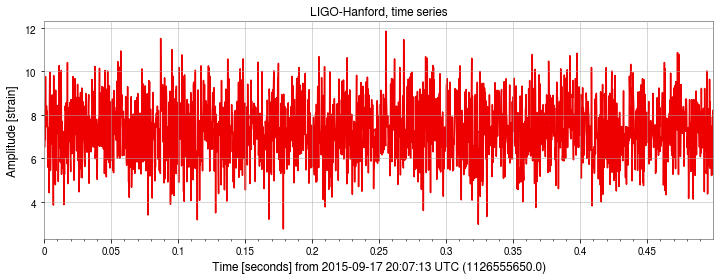

In [13]:
###################################################################
# Make time segments
print('>> Looping over time segments...')

data = {}   # will hold values to be written to parquet
nprint = 100 # Frequency of debug prints
nwrite = 0   # N segments actually written out after quality cuts

now = time.time()
for i in range(nsegs):
    
    if i%nprint == 0:
        print('.. %d / %d'%(i, nsegs))
    if i>200:
        pass
        break

    # Get time window for this segment
    tseg = timesegs[i]
    tstart, tend = tseg[0], tseg[-1]+dt # stride generates [t0, t1), so need to add +dt to get full t_window
    assert t_window == tend-tstart
    
    # Get data for this segment
    batch = series.crop(tstart, tend)
    dqs = series_dq.crop(tstart, tend)
    injs = series_inj.crop(tstart, tend)
    assert batch.duration.value == t_window
    #print(batch[0], batch[1], batch[2], batch[3])
    if i%nprint == 0:
        print(tstart, tend)
        print(batch[0], batch[1], batch[2], batch[3])
    
    # Quality cuts
    # NOTE: only needs to be checked for effective window
    # i.e. full window less truncated segments
    # Make sure no NaNs
    if np.any(np.isnan(batch.value[n_trunc:-n_trunc])):
        pass
        continue
    # Make sure DQ:CAT3 for both CBC and burst
    if np.any(dqs.value[n_trunc:-n_trunc] != 127):
        pass
        continue
    # Make sure there were no hardware injs
    if np.any(injs.value[n_trunc:-n_trunc] != 31):
        pass
        continue
        
    debug = True #if i%nprint == 0 else False
    inj_sg = False

    # Waveform processing
    if inj_sg:
        # Generate GW signal
        saveplot = '%s_sg_seg%05d.pdf'%(outname, i)
        #sg = make_bbh(m1s[i], m2s[i], dists[i], decs[i], ras[i], pols[i], tend-t_gwoffs[i], fcalib_lo, dt, debug=debug, saveplot=saveplot)
        sg = make_bbh(25., 25., 300., decs[i], ras[i], pols[i], tend-t_gwoffs[i]-0.1, fcalib_lo, dt, debug=debug, saveplot=saveplot)    
        # Inject signal into data
        sb = batch.inject(sg)
        # Process waveform
        saveplot = '%s_sgbg_seg%05d.pdf'%(outname, i)
        #wav = process_strain(sb, w=whiten_fft, fcalib_lo=fcalib_lo, fsg_lo=fsg_lo, fsg_hi=fsg_hi, t_trunc=t_trunc, dt=dt, debug=debug, saveplot=saveplot)
        wav = process_strain(sb, w=whiten_fft, fcalib_lo=fcalib_lo, fsg_lo=None, fsg_hi=None, t_trunc=t_trunc, dt=dt, debug=debug, saveplot=saveplot)
    else:
        # Process waveform
        saveplot = '%s_bg_seg%05d.pdf'%(outname, i)
        wav = process_strain(batch, w=whiten_fft, fcalib_lo=fcalib_lo, fsg_lo=None, fsg_hi=None, t_trunc=t_trunc, dt=dt, debug=debug, saveplot=saveplot)
    
    #plot_series(wav, ylims=[-2.5, 2.5])
    plot_series(wav)#, ylims=[-10., 10.])
    '''
    # Write to parquet
    # First, convert to dict
    data['strain'] = wav.value
    data['t0']     = wav.times.value[0]
    data['y']      = 1. if inj_sg else 0.
    data['m1']     = m1s[i]
    data['m2']     = m2s[i]
    data['dist']   = dists[i]
    data['dec']    = decs[i]
    data['ra']     = ras[i]
    data['pol']    = pols[i]
    data['toff']   = t_eff-t_gwoffs[i] # store offset from start time of this waveform instead
    # Then convert to pq arrays
    pqdata = [pa_array(d) for d in data.values()]
    # Then convert to pq table
    table = pa.Table.from_arrays(pqdata, list(data.keys()))
    # Write table to pq file
    if nwrite == 0:
        writer = pq.ParquetWriter(pqout, table.schema, compression='snappy')
    writer.write_table(table)
    '''
    nwrite += 1
    break

#writer.close()
proc_time = time.time() - now
print('>> Done.')
#print('deltat:',deltats[1]-deltats[0])
print('.. nwrite / nsegs: %d / %d'%(nwrite, nsegs))
print('.. processing time: %s'%('%f s'%proc_time if proc_time <= 60 else '%f min'%proc_time/60.))

7.2793983861637255


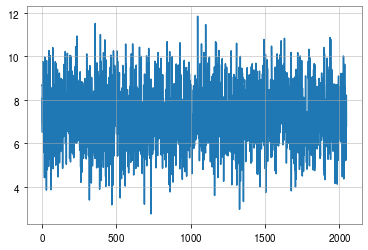

In [14]:
xstrain = wav.value
print(np.mean(xstrain))
plt.plot(xstrain)
plt.show()

In [33]:
# Do a read test
pqin = pq.ParquetFile('data/O1/parquet/m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_nobp/O1_H1_local_idx004_sgbg.parquet')
#print(pqin.metadata)
#print(pqin.schema)

(2048,)
-4.5634806e-08


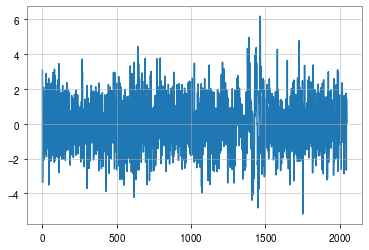

In [41]:
X = pqin.read_row_group(5, columns=['strain']).to_pydict()['strain']
X = np.float32(X).flatten()
X -= X.mean()
print(X.shape)
print(X.mean())
plt.plot(X)
plt.show()

In [9]:
# Do a read test
pqin = pq.ParquetFile(pqout)
print(pqin.metadata)
print(pqin.schema)
X = pqin.read_row_group(0, columns=['t0','y','m1','m2']).to_pydict()
print(X)

  created_by: parquet-cpp-arrow version 5.0.0
  num_columns: 10
  num_rows: 11
  num_row_groups: 11
  format_version: 1.0
  serialized_size: 10372
required group field_id=-1 schema {
  optional group field_id=-1 strain (List) {
    repeated group field_id=-1 list {
      optional float field_id=-1 item;
    }
  }
  optional float field_id=-1 t0;
  optional float field_id=-1 y;
  optional float field_id=-1 m1;
  optional float field_id=-1 m2;
  optional float field_id=-1 dist;
  optional float field_id=-1 dec;
  optional float field_id=-1 ra;
  optional float field_id=-1 pol;
  optional float field_id=-1 toff;
}

OrderedDict([('t0', [1126076416.0]), ('y', [0.0]), ('m1', [38.64207077026367]), ('m2', [15.395029067993164])])
